In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report

In [ ]:

print("Loading data...")
data = pd.read_csv('Intrusion.csv')
print(f"Data loaded with {data.shape[0]} rows and {data.shape[1]} columns")
print("\nFirst 5 rows:")
data.head()

Step 1: Loading data...
Data loaded with 22544 rows and 41 columns

First 5 rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [ ]:

print("Preprocessing data...")
for column in data.columns:
    if data[column].dtype == 'object':  
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  
        data[column].fillna(data[column].median(), inplace=True)

Step 2: Preprocessing data...


C:\Users\sehga\AppData\Local\Temp\ipykernel_22768\975893161.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)
C:\Users\sehga\AppData\Local\Temp\ipykernel_22768\975893161.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [ ]:

print("Converting categorical features to numeric...")


categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")


for column in categorical_columns:
    if column != 'class': 
        encoder = LabelEncoder()
        data[column] = encoder.fit_transform(data[column])
        print(f"Converted {column}")


target_column = 'class'
if target_column not in data.columns:
    target_column = data.columns[-1]

print(f"\nTarget column: {target_column}")
print(f"Target data type: {data[target_column].dtype}")
print(f"First few target values: {data[target_column].head()}")

Step 3: Converting categorical features to numeric...
Categorical columns: ['protocol_type', 'service', 'flag']
Converted protocol_type
Converted service
Converted flag

Target column: dst_host_srv_rerror_rate
Target data type: float64
First few target values: 0    1.00
1    1.00
2    0.00
3    0.00
4    0.71
Name: dst_host_srv_rerror_rate, dtype: float64


In [ ]:

X = data.drop(columns=[target_column])
y = data[target_column].values

# IMPORTANT: Convert continuous target to discrete classes
print("Step 3.5: Converting continuous target values to discrete classes...")
print(f"Original target range: {y.min()} to {y.max()}")


discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_discrete = discretizer.fit_transform(y.reshape(-1, 1)).flatten().astype(int)

print(f"After conversion - classes: {np.unique(y_discrete)}")
print(f"Class distribution:")
for i, count in enumerate(np.bincount(y_discrete)):
    print(f"  Class {i}: {count} samples")

Step 3.5: Converting continuous target values to discrete classes...
Original target range: 0.0 to 1.0
After conversion - classes: [0 1]
Class distribution:
  Class 0: 18032 samples
  Class 1: 4512 samples


C:\Users\sehga\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:

print("Step 4: Selecting important features...")

# Train a temporary Random Forest to get feature importance
rf_temp = RandomForestClassifier(n_estimators=50, random_state=42)
rf_temp.fit(X, y_discrete)  

# Get feature importance
feature_importances = pd.Series(rf_temp.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(10).index.tolist()

print("Top 10 features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}: {feature_importances[feature]:.4f}")

X = X[top_features]

Step 4: Selecting important features...
Top 10 features:
1. rerror_rate: 0.1939
2. flag: 0.1934
3. srv_rerror_rate: 0.1627
4. dst_host_rerror_rate: 0.1086
5. same_srv_rate: 0.0616
6. dst_host_same_srv_rate: 0.0530
7. src_bytes: 0.0451
8. diff_srv_rate: 0.0345
9. dst_host_srv_count: 0.0280
10. count: 0.0204


In [ ]:

print("Normalizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features normalized")


scaled_df = pd.DataFrame(X_scaled, columns=top_features)
scaled_df.describe()

Step 5: Normalizing features...
Features normalized


,rerror_rate,flag,srv_rerror_rate,dst_host_rerror_rate,same_srv_rate,dst_host_same_srv_rate,src_bytes,diff_srv_rate,dst_host_srv_count,count
count,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04
mean,-1.765010e-17,1.260722e-17,2.206263e-17,1.765010e-17,-3.435467e-16,-1.314302e-16,3.782165e-18,-1.638938e-17,7.769197e-17,-3.530021e-17
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-5.730790e-01,-2.141480e+00,-5.650541e-01,-6.027189e-01,-1.794832e+00,-1.397181e+00,-2.198811e-02,-3.630345e-01,-1.259158e+00,-6.148324e-01
25%,-5.730790e-01,-5.838492e-01,-5.650541e-01,-6.027189e-01,-1.188752e+00,-1.236512e+00,-2.198811e-02,-3.630345e-01,-1.124967e+00,-6.070525e-01
50%,-5.730790e-01,6.622558e-01,-5.650541e-01,-6.027189e-01,6.294875e-01,7.144681e-01,-2.187389e-02,-3.630345e-01,2.437744e-01,-5.525932e-01
75%,2.772593e-02,6.622558e-01,-3.908614e-01,3.269846e-01,6.294875e-01,8.980898e-01,-2.138106e-02,-1.314922e-01,1.022079e+00,3.440399e-01
max,1.830141e+00,9.737821e-01,1.837604e+00,1.979791e+00,6.294875e-01,8.980898e-01,1.328647e+02,3.496004e+00,1.022079e+00,3.360695e+00


In [ ]:

print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_discrete, test_size=0.2, random_state=42  
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Step 6: Splitting data into training and testing sets...
Training set: 18035 samples
Testing set: 4509 samples


In [ ]:

print(" Training models...")

# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# SVM 
print("Training SVM...")
svm_model = LinearSVC(random_state=42, max_iter=2000)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("Models trained successfully!")

Step 7: Training models...
Training Random Forest...
Training SVM...
Models trained successfully!


In [ ]:

print("Evaluating models...")


def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return accuracy, precision, recall, f1

# Evaluate Random Forest
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(y_test, rf_pred, "Random Forest")

# Evaluate SVM
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(y_test, svm_pred, "SVM")

Step 8: Evaluating models...

Random Forest Results:
Accuracy:  0.9978
Precision: 0.9978
Recall:    0.9978
F1-Score:  0.9978

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3624
           1       1.00      0.99      0.99       885

    accuracy                           1.00      4509
   macro avg       1.00      1.00      1.00      4509
weighted avg       1.00      1.00      1.00      4509


SVM Results:
Accuracy:  0.9940
Precision: 0.9941
Recall:    0.9940
F1-Score:  0.9940

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3624
           1       0.98      0.99      0.98       885

    accuracy                           0.99      4509
   macro avg       0.99      0.99      0.99      4509
weighted avg       0.99      0.99      0.99      4509



Creating model comparison chart...


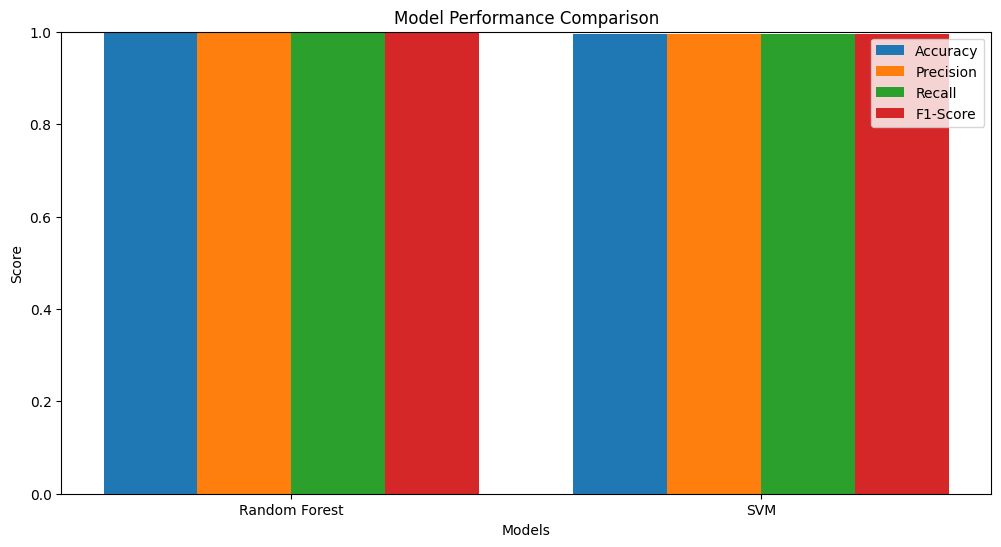

In [ ]:

print("Creating model comparison chart...")

plt.figure(figsize=(12, 6))
models = ['Random Forest', 'SVM']
metrics = {
    'Accuracy': [rf_accuracy, svm_accuracy],
    'Precision': [rf_precision, svm_precision],
    'Recall': [rf_recall, svm_recall],
    'F1-Score': [rf_f1, svm_f1]
}

# Plot bar chart
x = np.arange(len(models))
width = 0.2
i = 0
for metric, values in metrics.items():
    plt.bar(x + i*width, values, width, label=metric)
    i += 1

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, models)
plt.legend()
plt.ylim(0, 1)
plt.show()

Creating Random Forest confusion matrix...


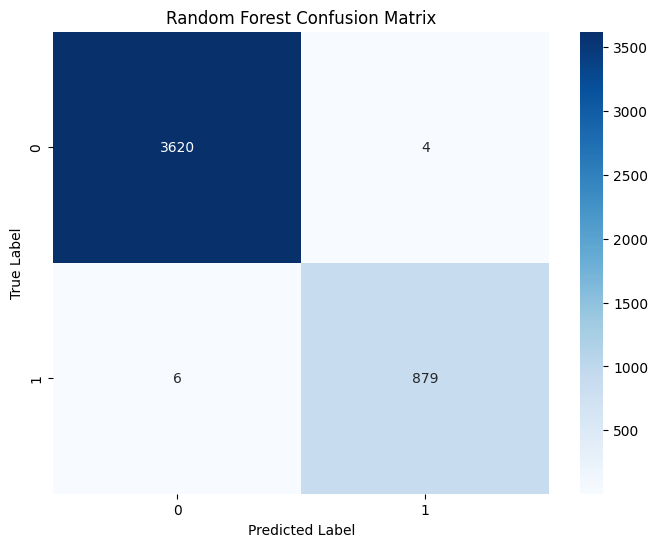

In [ ]:

print("Creating Random Forest confusion matrix...")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Creating feature importance chart...


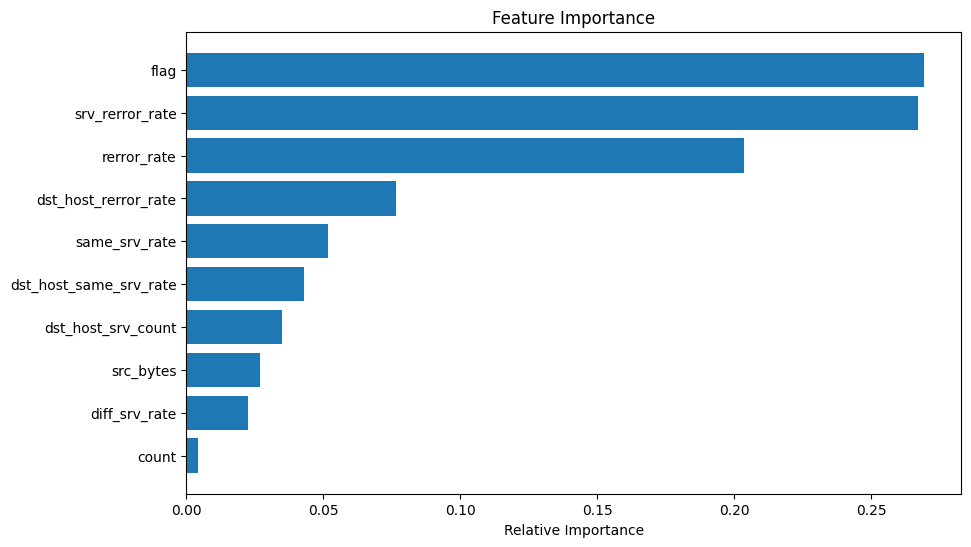

In [ ]:

print("Creating feature importance chart...")

plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [top_features[i] for i in indices])
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

In [8]:
print(f"Best model: {'Random Forest' if rf_f1 > svm_f1 else 'SVM'}")
print(f"Random Forest F1-Score: {rf_f1:.4f}")
print(f"SVM F1-Score: {svm_f1:.4f}")

NameError: name 'rf_f1' is not defined